In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [1]:
df = pd.read_parquet("results_without_fail.parquet")

NameError: name 'pd' is not defined

In [7]:
df[df.operator.apply(lambda x: 'Filenotfound' in x)].head()

,dataset,join,operator,model,tuple_ratio,feature_ratio,cardinality_T,cardinality_S,complexity,selectivity,times,num_cores,data_characteristics,profile_times,times_std,times_mean
index,,,,,,,,,,,,,,,,


In [8]:
df = df[~df.operator.apply(lambda operator_str: any([x in operator_str for x in ['Materialization', 'Noop']]))]


In [9]:
# handle failures
df['operator']= df.operator.apply(lambda operator_str: operator_str.split("= fail:")[0])

def get_op_type(operator: str):
    if operator in []:
        return 'scalar'
    else:
        return operator

scalar_ops = ['Left multiply', 'Row summation' , 'Column summation' , 'Left multiply T' , 'Row summation T', 'Column summation T', 'Right multiply']
df['operator_type'] = df.operator.apply(lambda operator_str: 'scalar' if operator_str in scalar_ops else operator_str)

In [10]:
from collections import defaultdict
materialized_complexity_dict = defaultdict(lambda: 0)
for dataset, operator, complexity in df[df.model == 'materialized'][['dataset', 'operator', 'complexity']].values:
    materialized_complexity_dict[(dataset, operator)] = complexity

def calc_complexity_ratio(row):
    if row[1] == 'Materialization':
        return None
    val = materialized_complexity_dict[(row[0], row[1])]
    if not val:
        return None
    return  val/ row[2]

df['complexity_ratio'] = df[['dataset', 'operator', 'complexity']].apply(calc_complexity_ratio, axis=1)

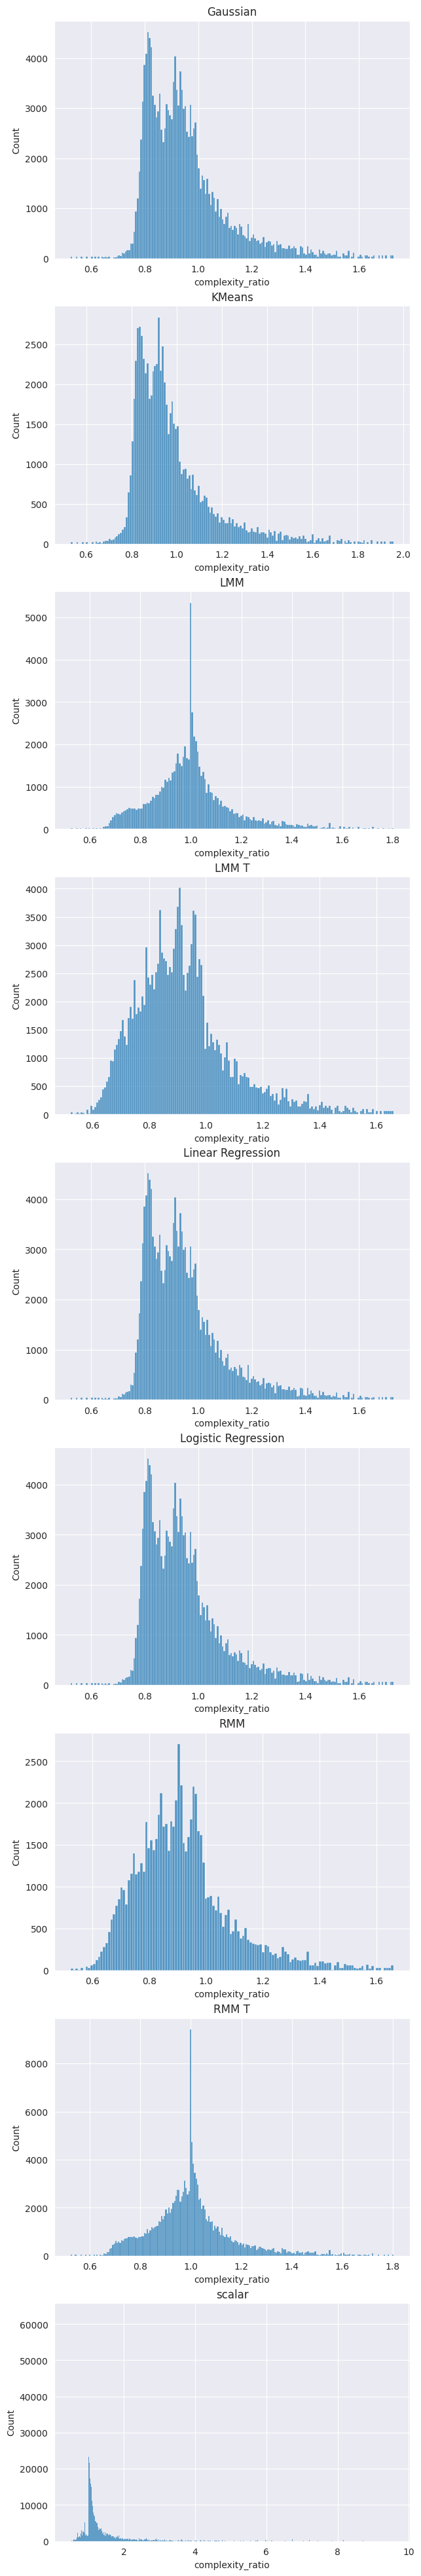

In [11]:
fig, axs = plt.subplots(len(df.operator_type.unique()),figsize=(7, 50), sharex=False, sharey=False)

for ax, (group, dfsub) in zip(axs, df[df.model!='materialized'].groupby('operator_type')):
    sns.histplot(data=dfsub, x='complexity_ratio', ax=ax)
    ax.set_title(group)

In [12]:
# Find datasets with complexity values closest to what we want.
matrix_mult_complexities = [0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
model_complexities = [0.8, 1, 1.2, 1.4, 1.6, 1.8]
wanted_complexity = {
    'scalar': [0.5, 1.0, 1.5, 2, 2.5, 3, 3.5, 4],
    ** {op: matrix_mult_complexities for op in ['LMM', 'RMM', 'LMM T', 'RMM T']},
    ** {model: model_complexities for model in  ["Linear Regression","Gaussian", "KMeans", "Logistic Regression"]}
}
fractions = {
    'scalar': 0.5,
    ** {op: 0.2 for op in ['LMM', 'RMM', 'LMM T', 'RMM T']},
    ** {model: 0.2 for model in  ["Linear Regression","Gaussian", "KMeans", "Logistic Regression"]}
}

def get_complexity_diff(row):
    ratio, op = row[0], row[1]
    return round(ratio * (1/fractions[op])) / (1/fractions[op])

df['complexity_rounded'] = df[['complexity_ratio' , 'operator_type']].apply(get_complexity_diff, axis=1)
df['complexity_difference'] = (df.complexity_rounded - df.complexity_ratio).abs()

In [13]:
valid_rows = df[df[['complexity_rounded', 'operator_type']].apply(lambda r: r[0] in wanted_complexity[r[1]],axis=1)]

In [18]:
# for each operator, complexity ratio find closest row
datasets = valid_rows.sort_values('complexity_difference').groupby(['operator_type', 'complexity_rounded']).head(5).dataset

In [29]:
datasets.apply(lambda x: '-'.join(x.replace('/data/', '').split('-')[3:])).to_list()

['rho_c_S=0.8-rho_c_R=0.4-p=0.8-join=outer-t_R=0.3-rho_r_S=0.6/ratio_1.5',
 'rho_c_S=0.6-rho_c_R=0.4-p=0.2-join=outer-t_R=0.6-rho_r_S=0.8/ratio_1.0',
 'rho_c_S=0.6-rho_c_R=0.4-p=0.2-join=outer-t_R=0.6-rho_r_S=0.8/ratio_1.0',
 'rho_c_S=0.2-rho_c_R=0.2-p=0.8-join=outer-t_R=0.9-rho_r_S=0.8/ratio_2.0',
 'rho_c_S=0.2-rho_c_R=0.2-p=0.8-join=outer-t_R=0.9-rho_r_S=0.8/ratio_2.0',
 'rho_c_S=0.2-rho_c_R=0.2-p=0.8-join=outer-t_R=0.9-rho_r_S=0.8/ratio_2.0',
 'rho_c_S=0.2-rho_c_R=0.2-p=0.8-join=outer-t_R=0.9-rho_r_S=0.8/ratio_2.0',
 'rho_c_S=0.6-rho_c_R=0.4-p=0.2-join=outer-t_R=0.6-rho_r_S=0.8/ratio_1.0',
 'rho_c_S=0.6-rho_c_R=0.4-p=0.2-join=outer-t_R=0.6-rho_r_S=0.8/ratio_1.0',
 'rho_c_S=0.6-rho_c_R=0.4-p=0.2-join=outer-t_R=0.6-rho_r_S=0.8/ratio_1.0',
 'rho_c_S=0.2-rho_c_R=0.2-p=0.8-join=outer-t_R=0.9-rho_r_S=0.8/ratio_2.0',
 'rho_c_S=0.2-rho_c_R=0.2-p=0.8-join=outer-t_R=0.9-rho_r_S=0.8/ratio_2.0',
 'rho_c_S=0.9-rho_c_R=0.6-p=0.5-join=left-t_R=0.7/ratio_1.0',
 'rho_c_S=0.2-rho_c_R=0.2-p=0.8-join=o

In [31]:
len(datasets)

290